In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn import preprocessing

## 8.1 (a) Load and Prepare Data

In [3]:
# Load data from csv 3 files
ACC = pd.read_csv('acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [4]:
ACC

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


In [5]:
HeartR

,timedelta,heartrate
0,-556410.36066,57
1,-556408.36062,56
2,-556403.36062,56
3,-556399.36062,57
4,-556389.36062,59
...,...,...
4873,16959.47229,72
4874,16964.47229,74
4875,16970.47229,75
4876,16975.47229,76


In [6]:
SleepL

,timedelta,sleep
0,0,-1
1,30,-1
2,60,-1
3,90,-1
4,120,-1
...,...,...
562,16860,0
563,16890,0
564,16920,0
565,16950,0


In [7]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
print("ACC Start :" , ACC_min_date , "ACC end :" , ACC_max_date)
print("HeartR Start :" , HeartR_min_date , "HeartR end :" , HeartR_max_date)
print("SleepL Start :" , SleepL_min_date , "SleepL end :" , SleepL_max_date)

ACC Start : -124489.16105 ACC end : 17643.046417
HeartR Start : -556410.36066 HeartR end : 16980.47229
SleepL Start : 0 SleepL end : 16980


In [8]:
# select only intersected timedelta (ACC)
ACC_new = ACC[(ACC['timedelta'] > ACC_min_date) &(ACC['timedelta'] < ACC_max_date) ]
ACC_new

,timedelta,accX,accY,accZ
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
5,-124489.078316,0.019959,-0.593094,-0.806198
...,...,...,...,...
981994,17642.946943,0.506226,0.428665,-0.748779
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284


In [9]:
# select only intersected timedelta (HeartR)
HeartR_new = HeartR[(HeartR['timedelta'] > HeartR_min_date) &(HeartR['timedelta'] < HeartR_max_date) ]
HeartR_new

,timedelta,heartrate
1,-556408.36062,56
2,-556403.36062,56
3,-556399.36062,57
4,-556389.36062,59
5,-556163.88076,61
...,...,...
4872,16954.47226,73
4873,16959.47229,72
4874,16964.47229,74
4875,16970.47229,75


In [10]:
# select only intersected timedelta (HeartR)
SleepL_new = SleepL[(SleepL['timedelta'] > SleepL_min_date) &(SleepL['timedelta'] < SleepL_max_date) ]
SleepL_new

,timedelta,sleep
1,30,-1
2,60,-1
3,90,-1
4,120,-1
5,150,-1
...,...,...
561,16830,0
562,16860,0
563,16890,0
564,16920,0


## 8.1 (b) Load and Prepare Data (ACC)

In [11]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_6152\1200644162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
1,-2 days +13:25:11,0.018982,-0.589676,-0.809158
2,-2 days +13:25:11,0.020966,-0.580887,-0.815048
3,-2 days +13:25:11,0.019485,-0.580872,-0.813583
4,-2 days +13:25:11,0.016998,-0.587204,-0.806259
5,-2 days +13:25:11,0.019959,-0.593094,-0.806198
...,...,...,...,...
981994,0 days 04:54:03,0.506226,0.428665,-0.748779
981995,0 days 04:54:03,0.505249,0.425720,-0.748764
981996,0 days 04:54:03,0.508194,0.429138,-0.750717
981997,0 days 04:54:03,0.508179,0.427200,-0.747284


In [12]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()

In [13]:
df_acc_X

timedelta
-2 days +13:25:11    0.016081
-2 days +13:25:12    0.038944
-2 days +13:25:13    0.022542
-2 days +13:25:14    0.017970
-2 days +13:25:15    0.038620
                       ...   
0 days 04:53:59      0.504763
0 days 04:54:00      0.502466
0 days 04:54:01      0.502944
0 days 04:54:02      0.506228
0 days 04:54:03      0.506454
Name: accX, Length: 19593, dtype: float64

In [14]:
df_acc_Y

timedelta
-2 days +13:25:11   -0.585817
-2 days +13:25:12   -0.578258
-2 days +13:25:13   -0.567728
-2 days +13:25:14   -0.570523
-2 days +13:25:15   -0.565942
                       ...   
0 days 04:53:59      0.430875
0 days 04:54:00      0.428149
0 days 04:54:01      0.428004
0 days 04:54:02      0.428170
0 days 04:54:03      0.428505
Name: accY, Length: 19593, dtype: float64

In [15]:
df_acc_Z

timedelta
-2 days +13:25:11   -0.811041
-2 days +13:25:12   -0.818431
-2 days +13:25:13   -0.825828
-2 days +13:25:14   -0.821320
-2 days +13:25:15   -0.827241
                       ...   
0 days 04:53:59     -0.747636
0 days 04:54:00     -0.750749
0 days 04:54:01     -0.750483
0 days 04:54:02     -0.748264
0 days 04:54:03     -0.748301
Name: accZ, Length: 19593, dtype: float64

In [16]:
pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()

,timedelta,accX,accY,accZ
0,-2 days +13:25:11,0.016081,-0.585817,-0.811041
1,-2 days +13:25:12,0.038944,-0.578258,-0.818431
2,-2 days +13:25:13,0.022542,-0.567728,-0.825828
3,-2 days +13:25:14,0.017970,-0.570523,-0.821320
4,-2 days +13:25:15,0.038620,-0.565942,-0.827241
...,...,...,...,...
19588,0 days 04:53:59,0.504763,0.430875,-0.747636
19589,0 days 04:54:00,0.502466,0.428149,-0.750749
19590,0 days 04:54:01,0.502944,0.428004,-0.750483
19591,0 days 04:54:02,0.506228,0.428170,-0.748264


## 8.1 (c) Load and Prepare Data (Heart rate)

In [17]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))
HeartR_new

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_6152\1656371470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))


,timedelta,heartrate
1,-7 days +13:26:32,56
2,-7 days +13:26:37,56
3,-7 days +13:26:41,57
4,-7 days +13:26:51,59
5,-7 days +13:30:36,61
...,...,...
4872,0 days 04:42:34,73
4873,0 days 04:42:39,72
4874,0 days 04:42:44,74
4875,0 days 04:42:50,75


In [18]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
-7 days +13:26:32,56.0
-7 days +13:26:33,56.0
-7 days +13:26:34,56.0
-7 days +13:26:35,56.0
-7 days +13:26:36,56.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


## 8.1 (d) Load and Prepare Data (Sleep Label)

In [19]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))
SleepL_new

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_6152\391249886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))


,timedelta,sleep
1,0 days 00:00:30,-1
2,0 days 00:01:00,-1
3,0 days 00:01:30,-1
4,0 days 00:02:00,-1
5,0 days 00:02:30,-1
...,...,...
561,0 days 04:40:30,0
562,0 days 04:41:00,0
563,0 days 04:41:30,0
564,0 days 04:42:00,0


In [20]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


## 8.1 (e) Merge Data and Standardized data

In [21]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,-2 days +13:25:11,0.018982,-0.589676,-0.809158,86.0,NaN
1,-2 days +13:25:11,0.020966,-0.580887,-0.815048,86.0,NaN
2,-2 days +13:25:11,0.019485,-0.580872,-0.813583,86.0,NaN
3,-2 days +13:25:11,0.016998,-0.587204,-0.806259,86.0,NaN
4,-2 days +13:25:11,0.019959,-0.593094,-0.806198,86.0,NaN
...,...,...,...,...,...,...
981993,0 days 04:54:03,0.506226,0.428665,-0.748779,76.0,0.0
981994,0 days 04:54:03,0.505249,0.425720,-0.748764,76.0,0.0
981995,0 days 04:54:03,0.508194,0.429138,-0.750717,76.0,0.0
981996,0 days 04:54:03,0.508179,0.427200,-0.747284,76.0,0.0


In [22]:
# Fill NA Heart rate w/ median
df['heartrate'] = df['heartrate'].fillna(df['heartrate'].median())
df


,timedelta,accX,accY,accZ,heartrate,sleep
0,-2 days +13:25:11,0.018982,-0.589676,-0.809158,86.0,NaN
1,-2 days +13:25:11,0.020966,-0.580887,-0.815048,86.0,NaN
2,-2 days +13:25:11,0.019485,-0.580872,-0.813583,86.0,NaN
3,-2 days +13:25:11,0.016998,-0.587204,-0.806259,86.0,NaN
4,-2 days +13:25:11,0.019959,-0.593094,-0.806198,86.0,NaN
...,...,...,...,...,...,...
981993,0 days 04:54:03,0.506226,0.428665,-0.748779,76.0,0.0
981994,0 days 04:54:03,0.505249,0.425720,-0.748764,76.0,0.0
981995,0 days 04:54:03,0.508194,0.429138,-0.750717,76.0,0.0
981996,0 days 04:54:03,0.508179,0.427200,-0.747284,76.0,0.0


In [23]:
# Fillna() # with 0 sleep
df['sleep'] = df['sleep'].fillna(0)
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,-2 days +13:25:11,0.018982,-0.589676,-0.809158,86.0,0.0
1,-2 days +13:25:11,0.020966,-0.580887,-0.815048,86.0,0.0
2,-2 days +13:25:11,0.019485,-0.580872,-0.813583,86.0,0.0
3,-2 days +13:25:11,0.016998,-0.587204,-0.806259,86.0,0.0
4,-2 days +13:25:11,0.019959,-0.593094,-0.806198,86.0,0.0
...,...,...,...,...,...,...
981993,0 days 04:54:03,0.506226,0.428665,-0.748779,76.0,0.0
981994,0 days 04:54:03,0.505249,0.425720,-0.748764,76.0,0.0
981995,0 days 04:54:03,0.508194,0.429138,-0.750717,76.0,0.0
981996,0 days 04:54:03,0.508179,0.427200,-0.747284,76.0,0.0


In [24]:
# Drop column
df = df.drop(['timedelta'], axis=1)
df

,accX,accY,accZ,heartrate,sleep
0,0.018982,-0.589676,-0.809158,86.0,0.0
1,0.020966,-0.580887,-0.815048,86.0,0.0
2,0.019485,-0.580872,-0.813583,86.0,0.0
3,0.016998,-0.587204,-0.806259,86.0,0.0
4,0.019959,-0.593094,-0.806198,86.0,0.0
...,...,...,...,...,...
981993,0.506226,0.428665,-0.748779,76.0,0.0
981994,0.505249,0.425720,-0.748764,76.0,0.0
981995,0.508194,0.429138,-0.750717,76.0,0.0
981996,0.508179,0.427200,-0.747284,76.0,0.0


In [25]:
feature_columns = df[['accX', 'accY', 'accZ', 'heartrate']]
label_columns = df[['sleep']]

In [26]:
feature_columns

,accX,accY,accZ,heartrate
0,0.018982,-0.589676,-0.809158,86.0
1,0.020966,-0.580887,-0.815048,86.0
2,0.019485,-0.580872,-0.813583,86.0
3,0.016998,-0.587204,-0.806259,86.0
4,0.019959,-0.593094,-0.806198,86.0
...,...,...,...,...
981993,0.506226,0.428665,-0.748779,76.0
981994,0.505249,0.425720,-0.748764,76.0
981995,0.508194,0.429138,-0.750717,76.0
981996,0.508179,0.427200,-0.747284,76.0


In [27]:
label_columns

,sleep
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
981993,0.0
981994,0.0
981995,0.0
981996,0.0


In [28]:
scaler = preprocessing.StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(feature_columns.values),index = feature_columns.index,columns=feature_columns.columns)
df_feature

,accX,accY,accZ,heartrate
0,0.075834,-1.277688,-0.727676,0.685224
1,0.080762,-1.253834,-0.735060,0.685224
2,0.077085,-1.253793,-0.733224,0.685224
3,0.070908,-1.270979,-0.724042,0.685224
4,0.078260,-1.286965,-0.723965,0.685224
...,...,...,...,...
981993,1.286063,1.486176,-0.651979,-0.650449
981994,1.283638,1.478183,-0.651960,-0.650449
981995,1.290953,1.487460,-0.654409,-0.650449
981996,1.290915,1.482200,-0.650104,-0.650449


In [29]:
df_label = label_columns
df_label

,sleep
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
981993,0.0
981994,0.0
981995,0.0
981996,0.0


(<AxesSubplot:>, <AxesSubplot:>)

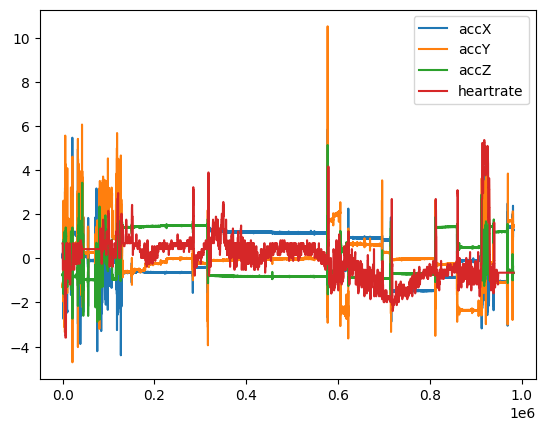

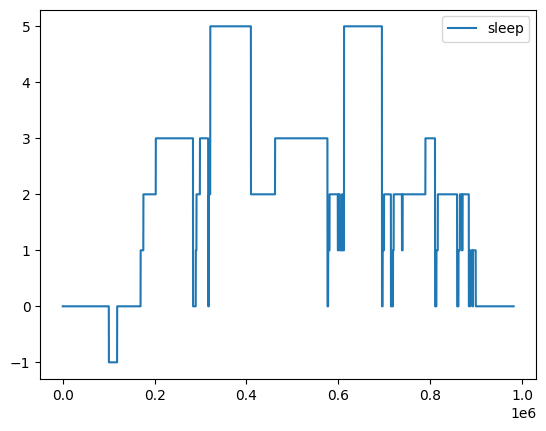

In [30]:
# Visualize signals
df_feature.plot(), df_label.plot()

## 8.2 (a) SVM Model Training and Testing

In [31]:
from sklearn import model_selection
seed= 26
x_train, x_test, y_train, y_test = model_selection.train_test_split(df_feature,df_label,test_size = 0.3, random_state=seed)

In [32]:
# Model Traing Parameter
# Create SVC model
c_val = 100
gmm =0.1
d = 2

In [33]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [37]:
print(x_train)

            accX      accY      accZ  heartrate
108665 -0.279063  1.160209 -0.901108  -0.116180
381873  1.174902 -0.053583 -0.814622   0.551657
344196  1.213939 -0.092057 -0.803412   0.685224
570730  1.146818 -0.004425 -0.824627   0.150955
480644  1.151669 -0.032297 -0.815368   0.551657
...          ...       ...       ...        ...
679635  0.926239  0.605183 -0.875838  -1.451852
58470  -0.093238  0.252712 -0.967585   0.418089
448262  1.162660 -0.030972 -0.817166   0.150955
947518 -1.067804 -1.105076  1.196185  -1.051150
316213 -0.700854 -2.119959 -0.129157   0.551657

[687398 rows x 4 columns]


In [38]:
svc_rbf = svc_rbf.fit(x_train, y_train)
svc_rbf_pred = svc_rbf.predict(x_test)


c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
# svc_poly = svc_poly.fit(x_train, y_train)
# svc_poly_pred = svc_poly.predict(x_test)